# Self-Training

Zacznijmy od załadowania i przetasowania zbioru danych, aby spełnić wymóg losowego braku nieoznakowanych próbek:

In [1]:
import numpy as np

np.random.seed(1000)

from sklearn.datasets import load_iris
from sklearn.utils import shuffle

iris = load_iris()
X, Y = shuffle(iris['data'], iris['target'], random_state=1000)

In [2]:
print(X[0:5])
print('Ilosc cech to:',X.shape[1])
print('\n')
print(Y[0:5])
print('Klasy to:', np.unique(Y))

[[5.7 3.  4.2 1.2]
 [4.9 3.1 1.5 0.2]
 [6.1 3.  4.9 1.8]
 [6.9 3.2 5.7 2.3]
 [4.8 3.4 1.9 0.2]]
Ilosc cech to: 4


[1 0 2 2 0]
Klasy to: [0 1 2]


Możemy teraz założyć, że mamy tylko 20 (ze 150) oznaczonych próbek. Ponieważ tablice X
i Y są już przetasowane, możemy je bezpośrednio podzielić:

In [3]:
nb_samples = X.shape[0]
print('Ilosc probek: ',nb_samples)

print('Klasa 0: ',len(Y[Y==0]))
print('Klasa 1: ',len(Y[Y==1]))
print('Klasa 2: ',len(Y[Y==2]))

Ilosc probek:  150
Klasa 0:  50
Klasa 1:  50
Klasa 2:  50


In [4]:
nb_labeled = 20
nb_unlabeled = nb_samples - nb_labeled
nb_unlabeled_samples = 2

X_train = X[:nb_labeled]
Y_train = Y[:nb_labeled]

X_unlabeled = X[nb_labeled:]

W tym momencie dobrym pomysłem jest wytrenowanie Naiwnego Klasyfikatora Bayesowskiego (przy użyciu domyślnych parametrów) z całym oryginalnym zbiorem danych i ocena jego wydajności. Robimy to w celu porównania z późniejszymi podejściami.

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
nb0 = GaussianNB() #prawdopodobienstwa na podstawie frakcji
nb0.fit(X, Y)
print(classification_report(Y, nb0.predict(X), target_names=iris['target_names']))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.94      0.94      0.94        50
   virginica       0.94      0.94      0.94        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



Funkcja <i>classification_report</i> z biblioteki <i>scikit-learn</i> dostarcza kompleksowego raportu, który zawiera różne metryki oceny wydajności modelu klasyfikacji.

Precyzja (Precision): Precyzja to miara tego, ile z przewidzianych instancji pozytywnych jest rzeczywiście instancjami prawdziwie pozytywnymi. W raporcie znajdują się wartości precyzji dla każdej klasy w zbiorze danych. $$\frac{TP}{TP+FP}$$

Czułość (Recall): Czułość, znana również jako współczynnik prawdziwie pozytywnych, mierzy, ile z prawdziwych instancji pozytywnych jest prawidłowo zidentyfikowanych. W raporcie znajdują się wartości czułości dla każdej klasy.$$\frac{TP}{TP+FN}$$

Wsparcie (Support): Wsparcie to liczba wystąpień w każdej z klas w zbiorze danych.

Macro avg: Średnia dla wszystkich klas

Przykład wyliczania wartości TP,TN,FP,FN dla trzech klas:

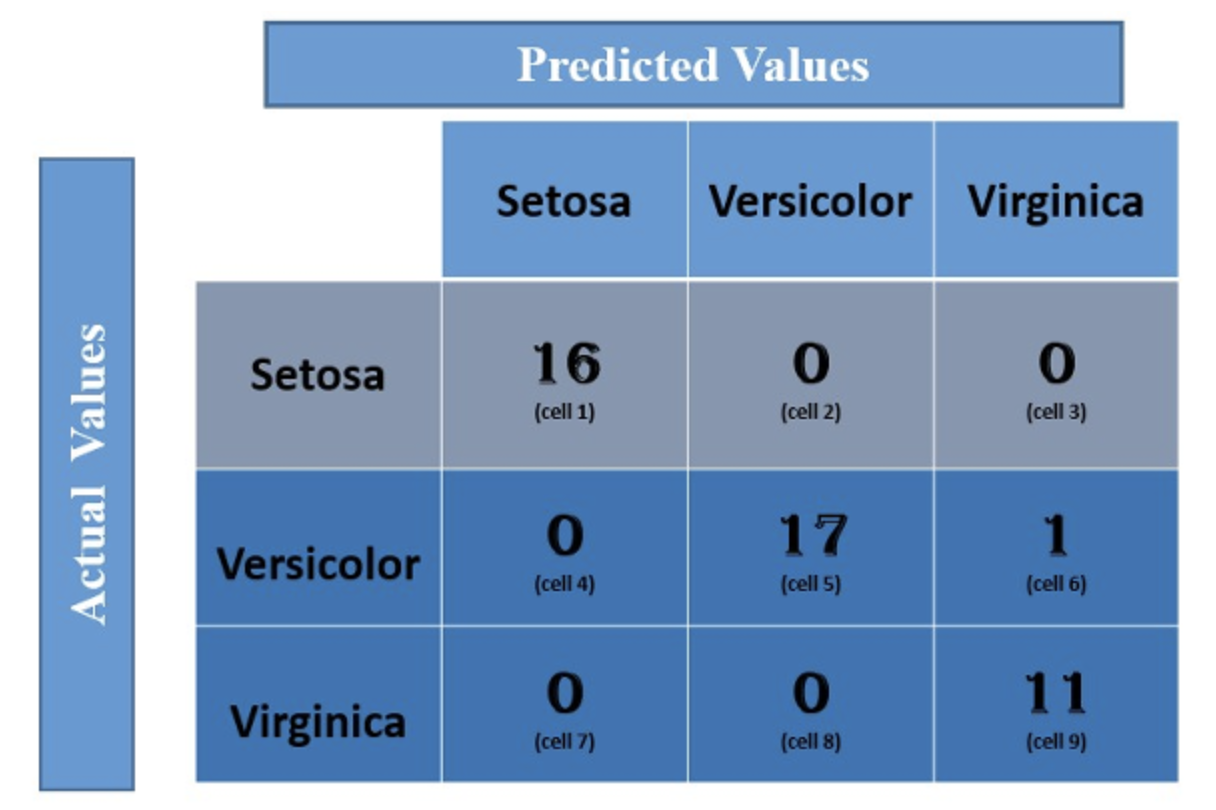

Obliczmy wartości TP, TN, FP i FN dla klasy Setosa:

TP: W przypadku klasy Setosa wartość komórki 1 jest wartością TP.

FN: Suma wartości odpowiednich wierszy z wyjątkiem wartości TP.
<br>
FN = (komórka 2 + komórka3)= (0 + 0) = 0

FP: Suma wartości odpowiednich kolumn z wyjątkiem wartości TP.
<br>

FP = (komórka 4 + komórka 7)= (0 + 0) = 0

TN: Suma wartości wszystkich kolumn i wierszy z wyjątkiem wartości tej klasy, dla której obliczamy wartości.
<br>
TN = (komórka 5 + komórka 6 + komórka 8 + komórka 9) = 17 + 1 +0 + 11 = 29

Wracając do analizy wyników, średnio klasyfikator ma zarówno precyzję, jak i czułość na poziomie 0,96, co wskazuje na obecność bardzo małej liczby wyników fałszywie pozytywnych i fałszywie negatywnych. Dla naszych celów możemy uznać tę wartość za punkt odniesienia.

Wytrenujmy teraz pół-nadzorowany model w oparciu o Self-Training:

In [6]:

#Caly proces Self-Training


nt = 0
nb = None

while X_train.shape[0] <= nb_samples:
    nt += 1

    nb = GaussianNB()
    nb.fit(X_train, Y_train)

    if X_train.shape[0] == nb_samples:
        break

    probs = nb.predict_proba(X_unlabeled)
    top_confidence_idxs = np.argsort(np.max(probs, axis=1)).astype(np.int64)[::-1]
    selected_idxs = top_confidence_idxs[0:nb_unlabeled_samples]

    X_new_train = X_unlabeled[selected_idxs]
    Y_new_train = nb.predict(X_new_train)

    X_train = np.concatenate((X_train, X_new_train), axis=0)
    Y_train = np.concatenate((Y_train, Y_new_train), axis=0)

    X_unlabeled = np.delete(X_unlabeled, selected_idxs, axis=0)


In [54]:
#Pierwsza iteracja procesu - posluzy nam w zrozumieniu algorytmu

nb = None #przechowuje klasyfikator Gaussian Naive Bayes

for i in range(1): #tutaj iterujemy tylko raz

    nb = GaussianNB() #tworzymy klasyfikator
    nb.fit(X_train, Y_train) #trenujemy na zbiorze treningowym

    if X_train.shape[0] == nb_samples: #sprawdzamy czy wszystkie probki sa juz oznaczone
        break #wtedy proces Self-Training sie konczy

    probs = nb.predict_proba(X_unlabeled)
    #uzywamy klasyfikatora do predykcji prawdopodobienstw klas nieoznakowanego zbioru
    #dla kazdego punktu nieoznaczonego zwraca tablice 3 prawdopodobienstw
    
    print(probs)
    print(len(probs))
    print('\n')
    
    top_confidence_idxs = np.argsort(np.max(probs, axis=1)).astype(np.int64)[::-1]
    #dla kazdego punktu liczymy maksymalne prawdopodobienstwo sposrod klas (z tablicy probs), 
    #a nastepnie sortujemy malejaco
    
    print(top_confidence_idxs)
    print(len(top_confidence_idxs))
    print('\n')

    
    selected_idxs = top_confidence_idxs[0:nb_unlabeled_samples]
    #bierzemy pierwsze nb_unlabeled_samples indeksow
    print(selected_idxs)
    print('\n')
        
    X_new_train = X_unlabeled[selected_idxs] #wyodrebniamy punkty odpowiadajace indeksom
    print(X_new_train)
    
    Y_new_train = nb.predict(X_new_train) #przewidujemy etykiety dla nowego zbioru
    print(Y_new_train)

    X_train = np.concatenate((X_train, X_new_train), axis=0)
    #dolaczamy nowo oznakowane punkty do zbioru treningowego
    
    Y_train = np.concatenate((Y_train, Y_new_train), axis=0)
    #dolaczamy odpowiadajace etykiety

    X_unlabeled = np.delete(X_unlabeled, selected_idxs, axis=0)
    #usuwamy juz oznaczone punkty ze zbioru nieoznaczonych

[[2.87668883e-045 9.99999167e-001 8.32792310e-007]
 [1.75752739e-139 9.40388813e-003 9.90596112e-001]
 [3.03594947e-197 4.42708914e-018 1.00000000e+000]
 [3.55021019e-227 2.95710565e-012 1.00000000e+000]
 [2.31400243e-032 9.99999901e-001 9.91160282e-008]
 [1.00000000e+000 4.03254431e-043 2.46211781e-027]
 [1.72466355e-110 7.81150058e-001 2.18849942e-001]
 [1.05934993e-083 9.98932988e-001 1.06701204e-003]
 [9.38942295e-040 9.99999830e-001 1.70413364e-007]
 [3.36440936e-168 5.38800179e-010 9.99999999e-001]
 [1.00000000e+000 2.77574692e-035 1.46206316e-027]
 [2.21887189e-057 9.99971655e-001 2.83449886e-005]
 [6.39953715e-253 3.63803145e-021 1.00000000e+000]
 [8.75634730e-062 9.99995296e-001 4.70355876e-006]
 [1.00000000e+000 1.25071856e-047 5.11424564e-035]
 [4.22088495e-185 6.02789280e-014 1.00000000e+000]
 [1.30320140e-174 2.00316179e-008 9.99999980e-001]
 [1.17711026e-099 9.97462340e-001 2.53765969e-003]
 [3.02998619e-161 2.95005134e-005 9.99970499e-001]
 [8.94126031e-230 4.37142010e-0

In [22]:
print(probs[64], probs[81])

[1.00000000e+00 4.28920356e-55 1.33468298e-38] [1.00000000e+00 6.93124294e-49 2.04937310e-35]


In [25]:
# wyjasnienie wyliczania zmiennej top_confidence_idxs
print(np.max(probs, axis=1)) #zwraca najwieksze prawdopodobienstwa w wierszach
print(np.argsort(np.max(probs, axis=1)).astype(np.int64)[::-1]) #zwraca odpowiadajace indeksy w kolejnosci malejacej

[0.99999917 0.99059611 1.         1.         0.9999999  1.
 0.78115006 0.99893299 0.99999983 1.         1.         0.99997166
 1.         0.9999953  1.         1.         0.99999998 0.99746234
 0.9999705  1.         0.99480365 1.         1.         0.96029873
 0.99963935 0.9995188  0.9999705  1.         0.93286723 1.
 1.         1.         0.99999622 1.         0.99003582 0.99821063
 1.         0.99999999 0.9999998  0.98342534 0.99996165 1.
 1.         0.9999822  1.         1.         0.99999906 0.90881842
 1.         1.         1.         0.88475346 1.         0.9707736
 0.99996866 1.         1.         1.         0.91065498 1.
 0.91245447 1.         0.99999575 0.79250364 1.         1.
 1.         1.         0.99871773 0.99993755 1.         0.99999996
 0.94532375 0.99999992 0.9994862  1.         1.         1.
 1.         0.64052782 1.         1.         0.99999688 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99999899 0.99

Proces ten jest prosty: klasyfikator Gaussa Naive Bayesa jest trenowany na podstawie zbioru treningowego, który jest budowany przyrostowo, jak pokazano na poniższym rysunku, gdzie bloki od $M_2$ do $M_n$ są tworzone podobnie jak $M_1$, poprzez dodanie $k$ punktów oznaczonych przez model zbudowany w poprzednim bloku:
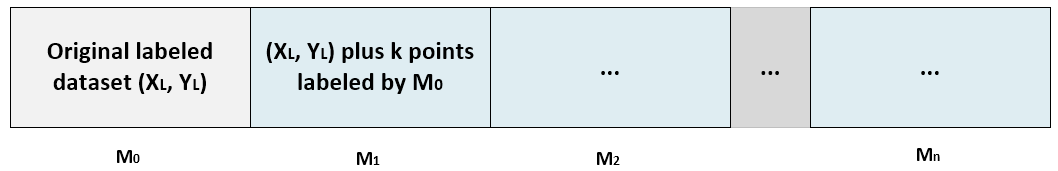


Zatem po każdym kroku uczenia, liczba <i>nb_unlabeled_samples</i> punktów o najwyższej pewności (w naszym przypadku woleliśmy być ostrożni i ograniczyliśmy tę liczbę do 2 punktów) jest wybieranych za pomocą metody <i>predict_proba()</i>. 

Są one następnie oznaczane przy użyciu wcześniej wytrenowanego klasyfikatora i dodawane do zbioru uczącego. Proces ten jest powtarzany do momentu, aż wszystkie nieoznakowane punkty zostaną oznaczone i dodane do zbioru uczącego.
<br>
<br>
Możemy teraz ocenić wydajność ostatecznego klasyfikatora:

In [7]:
print(classification_report(Y, nb.predict(X), target_names=iris['target_names']))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.95      0.70      0.80        50
   virginica       0.76      0.96      0.85        50

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.88       150
weighted avg       0.90      0.89      0.88       150



Zgodnie z oczekiwaniami, ostateczne wyniki są gorsze niż w przypadku podejścia nadzorowanego, ze średnią precyzją i przywołaniem równymi 0,9. Są one jednak całkiem rozsądne, biorąc pod uwagę, że użyliśmy tylko 20 etykietowanych próbek (13% oryginalnego zbioru danych), a model wstępny został zamiast tego przeszkolony przy użyciu całego zbioru danych.
<br>
Oczywiście ceną do zapłacenia jest wielokrotne trenowanie klasyfikatora. W naszym przypadku:


$$N_{training} = 1 + \frac{{N_{total points} - N_{labeled points}}}{{N_{unlabeled points}}} = 1 + \frac{{150 - 20}}{2} = 66$$

In [8]:
print(nt)

66


Możliwe jest zmniejszenie tej wartości poprzez zwiększenie liczby nieoznakowanych punktów dodawanych w każdej iteracji, ale może to prowadzić do gorszych wyników końcowych. Ogólnie rzecz biorąc, wyższą dokładność można osiągnąć poprzez zmniejszenie liczby nieoznakowanych punktów i zwiększenie liczby iteracji. I odwrotnie, szybkość można zmaksymalizować, zwiększając liczbę nieznakowanych punktów.

## Podsumowanie

Self-Training jest prostym i skutecznym algorytmem, który wykorzystuje nieoznakowane próbki danych. Algorytm polega on iteracyjnym ocenianiu nieoznakowanych próbek, gdzie punkty sklasyfikowane z wystarczająco dużą ufnością są włączane do nowego zbioru treningowego. Procedura jest powtarzana, aż wszystkie punkty danych zostaną pomyślnie sklasyfikowane. Algorytm ten działa całkiem dobrze, gdy założenie klastra jest spełnione. Co więcej, wymaga on klasyfikatora, który zwraca prawdopodobieństwo (lub inną miarę ufności), aby zdecydować, które punkty są optymalnymi kandydatami do włączenia do zaktualizowanego zestawu treningowego.